In this notebook, I practice some basic machine learning analysis. 

First, I downloaded two different sets of precinct-level election
results for the state of Michigan over the period 2000-2010
(see details below). I picked Michigan because I did my undergraduate
and PhD studies there. After using the first dataset to produce simple red-blue
election maps for a few elections in order to get a
sense of how the data look, I switch to the second, more detailed,
dataset. For this dataset, I create a new feature ("precinct id") in order
to compare precinct-level results between different years, and
then I make several plots showing changes in precinct-level turnout
as a function of time and party. 

I then create a pandas dataframe object to contain all the
precinct-level data, and I use linear regression and neural networks
to generate models to "predict" the precinct-level results for a given election, using 
precinct-level results from other elections. I use the term "predict" carefully, since
this is not quite predicing election results from scratch (I cannot predict the 2018 midterm results with this method, for example), but rather fitting a model to a given election's results. The idea is to see how much of a given election's results can be explained as a linear combination of results from other elections. It turns out that we can explain most (>75%, in some cases nearly 100%) of the results this way!

In order to make predictions about future elections, I would have to create a model that makes additional assumptions. If I were to incorporate polling data or economic data into the model, this could give it true predictive power, but at that point it becomes more of an exercise in political science, and my goal here is just to practice some basic machine learning analysis. 

In addition to standard Python modules like scikit-learn and numpy, 
this notebook also uses cartopy (http://scitools.org.uk/cartopy/)
to make maps of the precinct-level results. 

For more information, please contact me (Mike Anderson) at
michevan@gmail.com.

Thank you for reading!

In [1]:
# data analysis
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import os

### mapping 
from cartopy import config
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature

In [2]:
### First we want to look at a map of precincts in MI to get a sense of the data
### We use a map of precincts from the Harvard Election Data Archive
### at https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/15964

### The precinct info is stored as a "shapefile"  
uf_shapefile = 'dataverse_files/MI_Shapefiles/mi_final.shp'  ### shapefile

### and we use the cartopy module to process these shapefiles and make a map from them
uf_shp = cartopy.io.shapereader.Reader(uf_shapefile)


precincts = uf_shp.records()                                 #list of precincts
precinct = next(precincts)


### see what data is available in the map, in addition to the shapefiles
print sorted(precinct.attributes.keys())


['AG06DEM', 'AG06OTH', 'AG06REP', 'ALAND10', 'AV', 'AWATER10', 'COUNTYFP10', 'DSHARE_AG0', 'DSHARE_GOV', 'DSHARE_PRS', 'DSHARE_SOS', 'FUNCSTAT10', 'GEOID10', 'GEOID10_1', 'GOV06DEM', 'GOV06OTH', 'GOV06REP', 'INTPTLAT10', 'INTPTLON10', 'LSAD10', 'MTFCC10', 'NAME10', 'NAMELSAD10', 'NDR', 'NDV', 'OID_', 'PRS08DEM', 'PRS08OTH', 'PRS08REP', 'PRS08TOT', 'SOS06DEM', 'SOS06OTH', 'SOS06REP', 'STATEFP10', 'TOTPOP', 'VAP', 'VTDI10', 'VTDST10']


In [3]:
### get the number of precincts in the map
### pick one variable (OID_) in order to count precincts


### make a function get_id to get the "OID_" property from the shapefile
get_id = lambda precinct: precinct.attributes['OID_']    
 
### list of all precincts, sorted by OID_
precincts_by_id = sorted(uf_shp.records(), key=get_id)[:]
N_precincts = len(precincts_by_id)

### get some other data from the map
dem08 = np.array([np.int(precinct.attributes['PRS08DEM']) for precinct in precincts_by_id])
rep08 = np.array([np.int(precinct.attributes['PRS08REP']) for precinct in precincts_by_id])
tot08 = np.array([np.int(precinct.attributes['PRS08TOT']) for precinct in precincts_by_id])
dem06 = np.array([np.int(precinct.attributes['GOV06DEM']) for precinct in precincts_by_id])
rep06 = np.array([np.int(precinct.attributes['GOV06REP']) for precinct in precincts_by_id])
oth06 = np.array([np.int(precinct.attributes['GOV06OTH']) for precinct in precincts_by_id])
totpop =np.array([np.int(precinct.attributes['TOTPOP']) for precinct in precincts_by_id]) 
voting_age_pop = np.array([np.int(precinct.attributes['VAP']) for precinct in precincts_by_id])




In [4]:
### let's plot some of the data we got from the map to make sure everything is working
### We will make maps of the way each precinct voted
### coloring precicts with an RGB color,
### with R corresponding to the Republican share of the vote (0-100%)
### and B corresponding to the Democratic share of the vote (0-100%)

### these two lines are purely cosmetic; they eliminate the error messages that occur
### when a precinct has zero voters
old_settings = np.seterr(all='ignore')  # backup error settings
np.seterr(divide='ignore')

### set RGB values for 2006 Governor's race results
colors06 = np.zeros([3,N_precincts])
blue = dem06.astype(float)/(dem06+rep06+oth06).astype(float)
red = rep06.astype(float)/(dem06+rep06+oth06).astype(float)
green = np.zeros(N_precincts)
for i in range(N_precincts):
    colors06[0,i] = red[i]
    colors06[1,i] = green[i]
    colors06[2,i] = blue[i]
    if ((dem06+rep06+oth06)[i]==0):     #precincts with no data are plotted in white 
        colors06[0,i] = 1.0
        colors06[1,i] = 1.0
        colors06[2,i] = 1.0

### set RGB values for 2008 Presidential race results
colors08 = np.zeros([3,N_precincts])
blue = dem08.astype(float)/tot08.astype(float)
red = rep08.astype(float)/tot08.astype(float)
green = np.zeros(N_precincts)
for i in range(N_precincts):
    colors08[0,i] = red[i]
    colors08[1,i] = green[i]
    colors08[2,i] = blue[i]
    if (tot08[i]==0):                   #precincts with no data are plotted in white
        colors08[0,i] = 1.0
        colors08[1,i] = 1.0
        colors08[2,i] = 1.0
        

[]

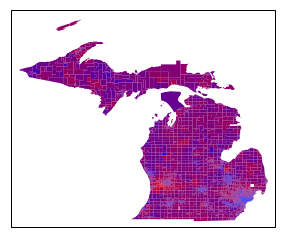

In [5]:
### Now that we have the map of precincts and two lists of RGB colors for each precinct, 
### let's make a map. 
### We will plot the results for the 2008 presidential election by precinct

### load shapefile again
uf_shapefile = 'dataverse_files/MI_Shapefiles/mi_final.shp'
uf_shp = cartopy.io.shapereader.Reader(uf_shapefile)

### get precincts again
precincts = uf_shp.records()

### initialize a map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90.7, -82.2, 41.5, 48.5])    #longitude and latitude, I used trial and error to get the box size right

### fill in the precinct boundaries and color each precinct with its RGB color for the 2008 election
### this takes a little while (~2 minutes) to run
for i in range(N_precincts):
    precinct = next(precincts)
    ax.add_geometries(precinct.geometry, ccrs.PlateCarree(),color=colors08[:,i],edgecolor='None')
ax.plot()




[]

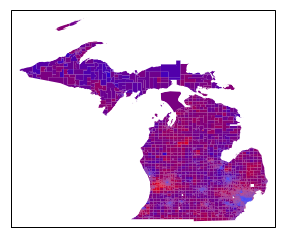

In [6]:
### For comparison, here is a plot of the results for the 2006 governors race by precinct

### load shapefile again
uf_shapefile = 'dataverse_files/MI_Shapefiles/mi_final.shp'
uf_shp = cartopy.io.shapereader.Reader(uf_shapefile)

### get precincts again
precincts = uf_shp.records()

### initialize another map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90.7, -82.2, 41.5, 48.5])    

### fill in the precinct boundaries and color each precinct with its RGB color for the 2006 election
### this also takes a little while (~2 minutes) to run
for i in range(N_precincts):
    precinct = next(precincts)
    ax.add_geometries(precinct.geometry, ccrs.PlateCarree(),color=colors06[:,i],edgecolor='None')
ax.plot()





In [7]:
### now we will use a larger and richer dataset:
### the full precinct-level results from 2000 - 2010
### also from the Harvard Election Data Archive
### https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/21919

### the first major issue is that there is no unique precinct id which persists between different years
### so I make my own "unique precinct id" feature
### by combining the county, town, ward, and precinct columns from these tables
### and I call it "new_feature"


def get_unique_precincts(year):
    ### creates a new_feature which combines city, town, precinct, and ward
    ### only works with 2000-2010 data
    ### office = pres, sen, rep, gov
    if (year != 2000) and (year != 2002) and (year != 2004) and (year != 2006) and (year != 2008) and (year != 2010):
        print "ERROR: no data for year "+str(year)
        return 0
    fname = 'dataverse_files/MI_'+str(year)+'.tab'
    df = pd.read_table(fname)
    new_feature = (df['county']+0.001*df['town']+1.0e-6*df['ward']+1.0e-9*df['precinct'])*(df['precinct'] < 100)*(df['town'] < 100)*(np.isnan(df['cd']) == False)#*(df['g2008_USP_dv'] > 0)
    return new_feature

In [8]:
### get unique precinct ids for each election, 2000-2010
nf00 = get_unique_precincts(2000)
nf02 = get_unique_precincts(2002)
nf04 = get_unique_precincts(2004)
nf06 = get_unique_precincts(2006)
nf08 = get_unique_precincts(2008)
nf10 = get_unique_precincts(2010)

In [9]:
### now select the unique values from these six files to be the final list of unique precinct ids
temp_precincts = np.concatenate([nf00,nf02,nf04,nf06,nf08,nf10])
print temp_precincts,len(temp_precincts)
### 34750 results overall for these six files

unique_precincts = np.unique(temp_precincts)
print unique_precincts,len(unique_precincts)
### 6012 unique precincts

### If there were data for each unique precinct every year, we would expect 6 * 6012 = 36072 results overall
### So the data are slightly incomplete (34750 / 36072 = 96.3%)
### Probably some precinct boundaries change over these ten years, which explains the incompleteness


[  1.002   0.      1.004 ...,  83.052  83.052  83.054] 34750
[  0.      1.002   1.004 ...,  83.052  83.052  83.054] 6012


In [10]:
### define a function to extract precinct-level data for a given election
### inputs are election year and which office the election is about (i.e. president, governor, etc)
### also input the list of unique precinct ids generated above, in order to output the data into
###    consistently indexed arrays

def get_info(year,precincts,office='pres'):
    ### returns four arrays of the votes for each precinct for dems, reps, total, and the number of rows combined into each precinct (for debugging)
    ### office can be one of: pres, sen, rep, gov
    if (year != 2000) and (year != 2002) and (year != 2004) and (year != 2006) and (year != 2008) and (year != 2010):
        print "ERROR: no data for year "+str(year)
        return 0
    prefix = 'g'+np.str(year)+'_'
    if office == 'pres':
        if (year == 2000) or (year == 2004) or (year == 2008):         # presidential elections
            prefix+='USP_'
        else:
            print "ERROR: no presidential election this year"
            return 0
    elif office == 'sen':
        if (year == 2000) or (year == 2002) or (year == 2006) or (year == 2008):  # Senate elections
            prefix+='USS_'
        else:
            print "ERROR: no senate election this year"
            return 0
    elif office == 'gov':
        if (year == 2002) or (year == 2006) or (year == 2010):  # Gubernatorial elections
            prefix+='GOV_'
        else:
            print "ERROR: no gubernatorial election this year"
            return 0
    elif office == 'rep':                 # House of Representatives elections
        prefix+='USH_'
    dem_string = prefix+'dv'
    rep_string = prefix+'rv'
    tot_string = prefix+'tv'
    fname = 'dataverse_files/MI_'+str(year)+'.tab'
    df = pd.read_table(fname)
    new_feature = (df['county']+0.001*df['town']+1.0e-6*df['ward']+1.0e-9*df['precinct'])*(df['precinct'] < 100)*(df['town'] < 100)*(np.isnan(df['cd']) == False)#*(df['g2008_USP_dv'] > 0)
    N = len(precincts)
    dem_votes = np.zeros(N)
    rep_votes = np.zeros(N)
    tot_votes = np.zeros(N)
    rows = np.zeros(N)
    for i in range(N):
        a ,= np.where(new_feature == precincts[i])
        if (len(a) > 0):
            if df[tot_string][a].sum() > 0:
                rep_votes[i] = np.int((df[rep_string][a]).sum())     # note the INT type 
                dem_votes[i] = np.int((df[dem_string][a]).sum())
                tot_votes[i] = np.int(df[tot_string][a].sum())
                rows[i] = len(a)
            else:
                pass
        else:
            pass
    return dem_votes,rep_votes,tot_votes,rows

In [11]:
# get the data 

# Presidential elections
d00,r00,t00,rows00 = get_info(2000,unique_precincts,office='pres')
d04,r04,t04,rows04 = get_info(2004,unique_precincts,office='pres')
d08,r08,t08,rows08 = get_info(2008,unique_precincts,office='pres')

# Senate elections
d00_sen,r00_sen,t00_sen,rows00_sen = get_info(2000,unique_precincts,office='sen')
d02_sen,r02_sen,t02_sen,rows02_sen = get_info(2002,unique_precincts,office='sen')
d06_sen,r06_sen,t06_sen,rows06_sen = get_info(2006,unique_precincts,office='sen')
d08_sen,r08_sen,t08_sen,rows08_sen = get_info(2008,unique_precincts,office='sen')

# House elections
d00_rep,r00_rep,t00_rep,rows00_rep = get_info(2000,unique_precincts,office='rep')
d02_rep,r02_rep,t02_rep,rows02_rep = get_info(2002,unique_precincts,office='rep')
d04_rep,r04_rep,t04_rep,rows04_rep = get_info(2004,unique_precincts,office='rep')
d06_rep,r06_rep,t06_rep,rows06_rep = get_info(2006,unique_precincts,office='rep')
d08_rep,r08_rep,t08_rep,rows08_rep = get_info(2008,unique_precincts,office='rep')
d10_rep,r10_rep,t10_rep,rows10_rep = get_info(2010,unique_precincts,office='rep')

# Governor elections
d02_gov,r02_gov,t02_gov,rows02_gov = get_info(2002,unique_precincts,office='gov')
d06_gov,r06_gov,t06_gov,rows06_gov = get_info(2006,unique_precincts,office='gov')
d10_gov,r10_gov,t10_gov,rows10_gov = get_info(2010,unique_precincts,office='gov')


4744
6012


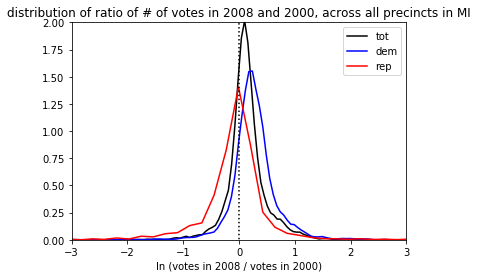

In [12]:
### We now have a very rich and useful dataset!
### Let's look at a few interesting results which we can immediately obtain from the data


### first, the ratio of the total votes for president in 2000 and 2008

### we will use a filter called "ok" to exclude a few glitchy precincts
ok = np.where((t00>0)*(t04>0)*(t08>0)*(d00 < 1.0e5))    # exclude precincts with zero votes, and also the first precinct (id = 0, which collects errors)
print len(ok[0])
print len(t00)
### 4744 precincts are ok out of 6012 total


### plot the ratio of votes in 2008 / votes in 2000
### use the natural log of the ratio so that Gaussian noise would produce a Gaussian distribution
bins = np.linspace(-4,4,81)

g = sns.distplot(np.log((t08/t00)[ok]),color='k',bins=bins,hist=False,label='tot')
g = sns.distplot(np.log((d08/d00)[ok]),color='b',bins=bins,hist=False,label='dem')


### there are some precincts with zero GOP votes so we have to add a small float to avoid dividing by zero
g = sns.distplot(np.log(((r08+1.0e-4)/(r00+1.0e-4))[ok]),color='r',bins=bins,hist=False,label='rep',axlabel='ln (votes in 2008 / votes in 2000)')
g.plot([0,0],[-10,10],':k')

#g = sns.lmplot('X', 'Y', df, col='Z', sharex=False, sharey=False)
g.set(xlim=(-3, 3))
g.set(ylim=(0,2))
g.set(title='distribution of ratio of # of votes in 2008 and 2000, across all precincts in MI')


### note that the total 2008 vote is greater than the 2000 vote (the peak is to the right of unity)
### this is due to a combination of population growth and changes in turnout
### we can disentangle these to some degree: note that 
###     the republican vote is unchanged, but the democratic vote is up a lot



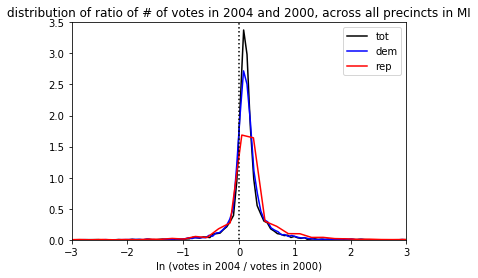

In [13]:
### Here is the ratio of presidential votes in 2004 / 2000

bins = np.linspace(-4,4,81)
g = sns.distplot(np.log((t04/t00)[ok]),color='k',bins=bins,hist=False,label='tot')
g = sns.distplot(np.log((d04/d00)[ok]),color='b',bins=bins,hist=False,label='dem')
g = sns.distplot(np.log(((r04+1.0e-4)/(r00+1.0e-4))[ok]),color='r',bins=bins,hist=False,label='rep',axlabel='ln (votes in 2004 / votes in 2000)')
g.plot([0,0],[-10,10],':k')

#g = sns.lmplot('X', 'Y', df, col='Z', sharex=False, sharey=False)
g.set(xlim=(-3, 3))
g.set(ylim=(0,3.5))
g.set(title='distribution of ratio of # of votes in 2004 and 2000, across all precincts in MI')


### like the previous plot, the total vote is higher in 2004 than 2000, but not by as much (less population growth)
### this time there is no differnce in turnout between dems and reps



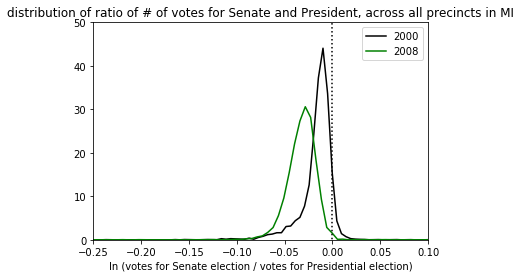

In [14]:
### And here is the dropoff in the senate turnout as compared to the presidential election
### note that, while the x axis is in log units, for small values of X, exp(-X) is about X
### so we are talking about dropoffs of a few percent

bins = np.linspace(-1,1,2001)
g = sns.distplot(np.log((t00_sen/t00)[ok]),color='k',bins=bins,hist=False,label='2000')
g = sns.distplot(np.log((t08_sen/t08)[ok]),color='g',bins=bins,hist=False,label='2008',axlabel='ln (votes for Senate election / votes for Presidential election)')
g.plot([0,0],[-100,100],':k')

#g = sns.lmplot('X', 'Y', df, col='Z', sharex=False, sharey=False)
g.set(xlim=(-0.25, 0.10))
g.set(ylim=(0,50))
g.set(title='distribution of ratio of # of votes for Senate and President, across all precincts in MI')





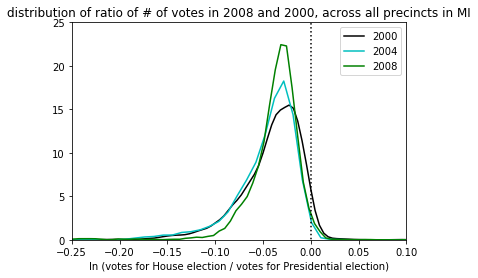

In [15]:
### And here is the dropoff in the House turnout as compared to the presidential election

bins = np.linspace(-1,1,2001)
g = sns.distplot(np.log((t00_rep/t00)[ok]),color='k',bins=bins,hist=False,label='2000')
g = sns.distplot(np.log((t04_rep/t04)[ok]),color='c',bins=bins,hist=False,label='2004')
g = sns.distplot(np.log((t08_rep/t08)[ok]),color='g',bins=bins,hist=False,label='2008',axlabel='ln (votes for House election / votes for Presidential election)')
g.plot([0,0],[-100,100],':k')

#g = sns.lmplot('X', 'Y', df, col='Z', sharex=False, sharey=False)
g.set(xlim=(-0.25, 0.10))
g.set(ylim=(0,25))
g.set(title='distribution of ratio of # of votes in 2008 and 2000, across all precincts in MI')







In [16]:
### now we combine all the data into a pandas dataframe object 

#year precinct office votes 
#new features:  tot_pop_of_MI   mean_margin

df = pd.DataFrame({'Dem 2000 Pres' : d00,        #0
                   'Rep 2000 Pres' : r00,
                   'Tot 2000 Pres' : t00,
                   'Dem 2004 Pres' : d04,
                   'Rep 2004 Pres' : r04,
                   'Tot 2004 Pres' : t04,        #5
                   'Dem 2008 Pres' : d08,
                   'Rep 2008 Pres' : r08,
                   'Tot 2008 Pres' : t08,
                   'Dem 2002 Gov' : d02_gov,
                   'Rep 2002 Gov' : r02_gov,        #10
                   'Tot 2002 Gov' : t02_gov,        
                   'Dem 2006 Gov' : d06_gov,
                   'Rep 2006 Gov' : r06_gov,
                   'Tot 2006 Gov' : t06_gov,
                   'Dem 2010 Gov' : d10_gov,        #15
                   'Rep 2010 Gov' : r10_gov,
                   'Tot 2010 Gov' : t10_gov,
                   'Dem 2000 House' : d00_rep,
                   'Rep 2000 House' : r00_rep,
                   'Tot 2000 House' : t00_rep,        #20
                   'Dem 2002 House' : d02_rep,
                   'Rep 2002 House' : r02_rep,
                   'Tot 2002 House' : t02_rep,
                   'Dem 2004 House' : d04_rep,
                   'Rep 2004 House' : r04_rep,        #25
                   'Tot 2004 House' : t04_rep,
                   'Dem 2006 House' : d06_rep,
                   'Rep 2006 House' : r06_rep,
                   'Tot 2006 House' : t06_rep,
                   'Dem 2008 House' : d08_rep,        #30
                   'Rep 2008 House' : r08_rep,
                   'Tot 2008 House' : t08_rep,
                   'Dem 2010 House' : d10_rep,
                   'Rep 2010 House' : r10_rep,
                   'Tot 2010 House' : t10_rep,        #35
                   'Dem 2000 Sen' : d00_sen,
                   'Rep 2000 Sen' : r00_sen,
                   'Tot 2000 Sen' : t00_sen,
                   'Dem 2002 Sen' : d02_sen,
                   'Rep 2002 Sen' : r02_sen,        #40
                   'Tot 2002 Sen' : t02_sen,
                   'Dem 2006 Sen' : d06_sen,
                   'Rep 2006 Sen' : r06_sen,
                   'Tot 2006 Sen' : t06_sen,
                   'Dem 2008 Sen' : d08_sen,        #45
                   'Rep 2008 Sen' : r08_sen,
                   'Tot 2008 Sen' : t08_sen,
                   'precinct id' : unique_precincts})

Here we make our first model. I define the 2008 presidential election as the dependent variable,
and generate a model which predicts these results at the precinct level, using all the
other election results as independent variables. I use linear regression to solve for the
coefficients of the model. 

In [17]:
### use all elections other than the 2008 presidential election, to predict the 2008 presidential election

### drop the index column
print df.shape
train_df = df.drop("precinct id", axis=1)
print train_df.shape

### drop the first row
train_df = train_df.iloc[1:] 
print train_df.shape

X_train  = train_df.drop(["Tot 2008 Pres","Dem 2008 Pres","Rep 2008 Pres"], axis=1)
Y_train = train_df["Tot 2008 Pres"]

(6012, 49)
(6012, 48)
(6011, 48)


In [18]:
### perform the fitting with linear regression

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_train)

# List all the coefficients for the model
print('Coefficients: \n', reg.coef_)



('Coefficients: \n', array([-0.11192771, -0.02897521,  0.01199811,  0.17576537,  0.06058712,
       -0.07043567,  0.01253757,  0.08176833,  0.02290044, -0.01257655,
        0.03643973, -0.18212714, -0.22132699,  0.31358194,  0.07199952,
       -0.1128211 , -0.05267411,  0.03426709,  0.21181812,  0.0680006 ,
       -0.11686091,  0.01079408,  0.09624639,  0.04813436, -0.01888367,
        0.01217321, -0.19023725, -0.23780548,  0.28959797,  0.13041804,
        0.09479477,  0.14108809, -0.11012293, -0.20159398, -0.06157125,
        0.0876468 , -0.10656042,  0.00875142,  0.02473894,  0.00345333,
       -0.07463309,  0.4061994 ,  1.0273907 ,  0.006364  , -0.40363998]))


(array([13, 41, 42]),) [ 0.31358194  0.4061994   1.0273907 ]
Dem 2010 Gov
Tot 2008 House
Tot 2008 Sen


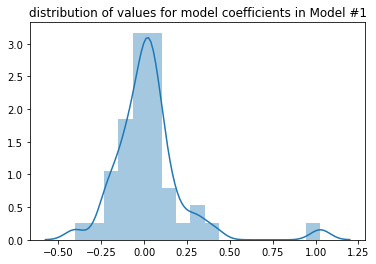

In [19]:
### find which coefficients are largest, and identify which elections correspond to them

print np.where(reg.coef_ > 0.3),reg.coef_[np.where(reg.coef_ > 0.3)]
print list(X_train.columns.values)[13]
print list(X_train.columns.values)[41]
print list(X_train.columns.values)[42]

### it makes sense that the other two 2008 elections would have strong correlations to the 2008 presidential election
### however it would be better to normalize each election to the same total population first, 
###   so the total number of voters for each election doesn't enter into the magnitude of the coefficients

sns.distplot(reg.coef_).set(title='distribution of values for model coefficients in Model #1')







Here we make our second model. As before, I define the 2008 presidential election as 
the dependent variable, and generate a model which predicts these results at the
precinct level. In this case, however, I drop the 2008 senate data and use the remaining
other election results as independent variables. I use linear regression to solve for the
coefficients of the model. 

In [20]:
### since the last exercise was dominated by the 2008 senate elections,
### now we try dropping the 2008 senate data as well and using the remaining elections to fit for the 2008 results

### drop the index column
print df.shape
train_df = df.drop("precinct id", axis=1)
print train_df.shape

### drop the first row
train_df = train_df.iloc[1:] 
print train_df.shape

X_train  = train_df.drop(["Tot 2008 Pres","Dem 2008 Pres","Rep 2008 Pres","Tot 2008 Sen","Dem 2008 Sen","Rep 2008 Sen"], axis=1)
Y_train = train_df["Tot 2008 Pres"]

(6012, 49)
(6012, 48)
(6011, 48)


In [21]:
### using linear regression again

reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_train)

# The coefficients
print('Coefficients: \n', reg.coef_)




('Coefficients: \n', array([-0.14434789, -0.23737532,  0.12627352,  0.24125906, -0.00240334,
        0.15493917,  0.19925254,  0.10649912,  0.15263301, -0.06548621,
        0.00288591, -0.70978945,  0.50650888,  0.12392205, -0.14638083,
       -0.28625813,  0.17221146,  0.31719079,  0.0188683 ,  0.07788463,
        0.1769687 ,  0.12926271,  0.18590184, -0.02952034, -0.05918423,
       -0.76919939,  0.41614038,  0.27476607,  0.12154076,  0.29191245,
       -0.16419113, -0.28748988, -0.04084131, -0.08569511, -0.3556558 ,
        0.05312201, -0.11987584,  0.04114578, -0.01378799,  1.74577267,
        0.3641364 , -1.01234322]))


(array([12, 17, 26, 39, 40]),) [ 0.50650888  0.31719079  0.41614038  1.74577267  0.3641364 ]
Dem 2010 Gov
Rep 2002 Gov
Rep 2010 Gov
Tot 2008 House
Tot 2010 Gov


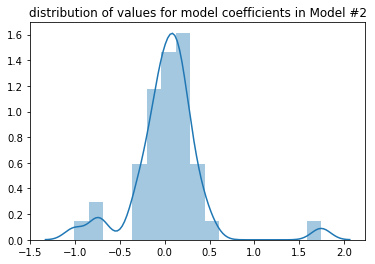

In [22]:
### and finding the elections that have the strongest coefficients in the model

print np.where(reg.coef_ > 0.3),reg.coef_[np.where(reg.coef_ > 0.3)]
print list(X_train.columns.values)[12]
print list(X_train.columns.values)[17]
print list(X_train.columns.values)[26]
print list(X_train.columns.values)[39]
print list(X_train.columns.values)[40]

### this time they are the 2008 house election and some governor races


sns.distplot(reg.coef_).set(title='distribution of values for model coefficients in Model #2')


Here I start the third model. This one is more realistic, in that I am not using any 2008 data to predict other
2008 data. Instead I just use data from 2000-2006 to fit a model to the 2008 presidential results.

For the first time, I also compute a "score" for the model. I use the R2 score, which tells us how much of the
variance in the data can be explained by the model. The result is that **76%** of the variance in the 2008 presidential election data can be explained by this simple model.

In [23]:
### now we do something more realistic. We use all the data from 2000-2006 to predict the 2008 presidential results

### drop the index column
print df.shape
train_df = df.drop("precinct id", axis=1)
print train_df.shape

### drop the first row
train_df = train_df.iloc[1:] 
print train_df.shape

X_train  = train_df[['Dem 2000 Pres','Rep 2000 Pres','Tot 2000 Pres','Dem 2004 Pres','Rep 2004 Pres','Tot 2004 Pres',
                    'Dem 2002 Gov','Rep 2002 Gov','Tot 2002 Gov','Dem 2006 Gov','Rep 2006 Gov','Tot 2006 Gov',
                    'Dem 2000 Sen' ,'Rep 2000 Sen' ,'Tot 2000 Sen','Dem 2002 Sen' ,'Rep 2002 Sen' ,'Tot 2002 Sen',
                    'Dem 2006 Sen' ,'Rep 2006 Sen' ,'Tot 2006 Sen','Dem 2000 House' ,'Rep 2000 House' ,'Tot 2000 House',
                    'Dem 2002 House' ,'Rep 2002 House' ,'Tot 2002 House','Dem 2004 House' ,'Rep 2004 House' ,'Tot 2004 House',
                    'Dem 2006 House' ,'Rep 2006 House' ,'Tot 2006 House']]
Y_train = train_df["Tot 2008 Pres"]

(6012, 49)
(6012, 48)
(6011, 48)


In [24]:
### running linear regression
reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_train)

# The coefficients
print('Coefficients: \n', reg.coef_)




('Coefficients: \n', array([-1.48415813, -2.43464295,  2.95515902,  0.45630513,  0.07272933,
        0.09636402,  0.66560267,  0.04847881, -0.25590701, -0.48966344,
       -0.24106319,  1.34074075,  0.06435241,  1.21911804, -1.63986444,
       -0.9409631 , -0.63363987,  0.70775565, -2.01121546, -2.1445643 ,
        1.93380198,  1.08988055,  1.05554986, -1.10506968, -0.20178032,
       -0.47578541,  0.26623282,  0.17905362, -0.01162092, -0.04182584,
       -1.85128576, -1.1065289 ,  1.24670559]))


In [25]:
### let's see how well we did! We can explain 76% of the variance in the 2008 results just from 2000-2006 data!
print "R2 score is {}".format(r2_score(Y_train, Y_pred))

score2 = np.sum((Y_train-Y_pred)**2 / (Y_train+1.0)) / len(Y_pred)
print "my custom chi^2-like score is {}".format(score2)



R2 score is 0.764424654737
my custom chi^2-like score is 14293.6208943


For the next step, I generate a new dataframe with values normalized to range between 0 and 1,
as Andrew Ng suggests in his "Machine Learning" course on Coursera. 

In [26]:
### now we do things a bit more rigourously, by normalizing all the results to the maximum number of votes 
###     per precinct in each election. Thus each precinct's values always range from 0-1, where 1 is
###     100% of the votes from the precinct going to a single candidate. 

#make new features:
### max votes 2000, 2002, 2004, 2006, 2008

max_votes_2000 = np.max([t00,t00_rep,t00_sen],axis=0).astype(int)
max_votes_2002 = np.max([t02_gov,t02_rep,t02_sen],axis=0).astype(int)
max_votes_2004 = np.max([t04,t04_rep],axis=0).astype(int)
max_votes_2006 = np.max([t06_rep,t06_sen,t06_gov],axis=0).astype(int)
max_votes_2008 = np.max([t08,t08_rep,t08_sen],axis=0).astype(int)
max_votes_2010 = np.max([t10_rep,t10_gov],axis=0).astype(int)

df2 = pd.DataFrame({'Dem 2000 Pres' : d00/max_votes_2000,        #0
                   'Rep 2000 Pres' : r00/max_votes_2000,
                   'Tot 2000 Pres' : t00/max_votes_2000,
                   'Dem 2004 Pres' : d04/max_votes_2004,
                   'Rep 2004 Pres' : r04/max_votes_2004,
                   'Tot 2004 Pres' : t04/max_votes_2004,        #5
                   'Dem 2008 Pres' : d08/max_votes_2008,
                   'Rep 2008 Pres' : r08/max_votes_2008,
                   'Tot 2008 Pres' : t08/max_votes_2008,
                   'Dem 2002 Gov' : d02_gov/max_votes_2002,
                   'Rep 2002 Gov' : r02_gov/max_votes_2002,        #10
                   'Tot 2002 Gov' : t02_gov/max_votes_2002,        
                   'Dem 2006 Gov' : d06_gov/max_votes_2006,
                   'Rep 2006 Gov' : r06_gov/max_votes_2006,
                   'Tot 2006 Gov' : t06_gov/max_votes_2006,
                   'Dem 2010 Gov' : d10_gov/max_votes_2010,        #15
                   'Rep 2010 Gov' : r10_gov/max_votes_2010,
                   'Tot 2010 Gov' : t10_gov/max_votes_2010,
                   'Dem 2000 House' : d00_rep/max_votes_2000,
                   'Rep 2000 House' : r00_rep/max_votes_2000,
                   'Tot 2000 House' : t00_rep/max_votes_2000,        #20
                   'Dem 2002 House' : d02_rep/max_votes_2002,
                   'Rep 2002 House' : r02_rep/max_votes_2002,
                   'Tot 2002 House' : t02_rep/max_votes_2002,
                   'Dem 2004 House' : d04_rep/max_votes_2004,
                   'Rep 2004 House' : r04_rep/max_votes_2004,        #25
                   'Tot 2004 House' : t04_rep/max_votes_2004,
                   'Dem 2006 House' : d06_rep/max_votes_2006,
                   'Rep 2006 House' : r06_rep/max_votes_2006,
                   'Tot 2006 House' : t06_rep/max_votes_2006,
                   'Dem 2008 House' : d08_rep/max_votes_2008,        #30
                   'Rep 2008 House' : r08_rep/max_votes_2008,
                   'Tot 2008 House' : t08_rep/max_votes_2008,
                   'Dem 2010 House' : d10_rep/max_votes_2010,
                   'Rep 2010 House' : r10_rep/max_votes_2010,
                   'Tot 2010 House' : t10_rep/max_votes_2010,        #35
                   'Dem 2000 Sen' : d00_sen/max_votes_2000,
                   'Rep 2000 Sen' : r00_sen/max_votes_2000,
                   'Tot 2000 Sen' : t00_sen/max_votes_2000,
                   'Dem 2002 Sen' : d02_sen/max_votes_2002,
                   'Rep 2002 Sen' : r02_sen/max_votes_2002,        #40
                   'Tot 2002 Sen' : t02_sen/max_votes_2002,
                   'Dem 2006 Sen' : d06_sen/max_votes_2006,
                   'Rep 2006 Sen' : r06_sen/max_votes_2006,
                   'Tot 2006 Sen' : t06_sen/max_votes_2006,
                   'Dem 2008 Sen' : d08_sen/max_votes_2008,        #45
                   'Rep 2008 Sen' : r08_sen/max_votes_2008,
                   'Tot 2008 Sen' : t08_sen/max_votes_2008,
                   'Max 2000' : max_votes_2000,
                   'Max 2002' : max_votes_2002,
                   'Max 2004' : max_votes_2004,          #50
                   'Max 2006' : max_votes_2006,
                   'Max 2008' : max_votes_2008,
                   'Max 2010' : max_votes_2010,
                   'precinct id' : unique_precincts})

In [27]:
df2

,Dem 2000 House,Dem 2000 Pres,Dem 2000 Sen,Dem 2002 Gov,Dem 2002 House,Dem 2002 Sen,Dem 2004 House,Dem 2004 Pres,Dem 2006 Gov,Dem 2006 House,...,Tot 2004 Pres,Tot 2006 Gov,Tot 2006 House,Tot 2006 Sen,Tot 2008 House,Tot 2008 Pres,Tot 2008 Sen,Tot 2010 Gov,Tot 2010 House,precinct id
0,0.503174,0.483372,0.462683,0.508701,0.464771,0.586773,0.426657,0.474093,0.550840,0.480621,...,1.0,0.998595,0.953849,1.000000,0.966130,1.000000,0.978323,1.000000,0.993461,0.000000
1,0.514286,0.435165,0.386813,0.441489,0.587766,0.523936,0.579677,0.427252,0.516418,0.670149,...,1.0,1.000000,0.991045,0.992537,0.988266,1.000000,0.988266,1.000000,0.985246,1.002000
2,0.468571,0.464762,0.392381,0.515663,0.643373,0.575904,0.570020,0.467456,0.574431,0.712785,...,1.0,0.994746,0.996497,1.000000,0.985097,1.000000,0.974665,1.000000,0.986328,1.004000
3,0.609148,0.555094,0.480249,0.488000,0.546667,0.594667,0.569524,0.535238,0.537815,0.702521,...,1.0,1.000000,0.969748,0.993277,0.961484,1.000000,0.971469,1.000000,0.964657,1.006000
4,0.585526,0.440789,0.376316,0.474157,0.519101,0.523596,0.501229,0.423833,0.517504,0.663623,...,1.0,1.000000,0.987823,0.998478,0.992874,1.000000,0.988124,1.000000,0.994966,1.008000
5,0.501695,0.447458,0.338983,0.536036,0.572072,0.612613,0.561562,0.414414,0.439344,0.701639,...,1.0,1.000000,0.996721,0.996721,0.997368,1.000000,0.989474,1.000000,0.983871,1.010000
6,0.474957,0.383420,0.309154,0.393321,0.536178,0.482375,0.498789,0.391041,0.454416,0.615385,...,1.0,1.000000,0.981481,0.988604,0.986335,1.000000,0.975155,1.000000,0.985612,1.012000
7,0.599542,0.517162,0.443936,0.560117,0.656891,0.627566,0.600000,0.487234,0.582031,0.755859,...,1.0,1.000000,0.982422,0.998047,0.988136,1.000000,0.979661,1.000000,0.995086,1.014000
8,0.516129,0.387097,0.366569,0.503650,0.631387,0.576642,0.579580,0.459459,0.501188,0.688836,...,1.0,1.000000,0.988124,0.985748,0.997732,1.000000,0.993197,1.000000,0.990937,1.016000
9,0.584488,0.390582,0.304709,0.382716,0.510288,0.502058,0.561983,0.388430,0.415789,0.668421,...,1.0,0.986842,0.976316,1.000000,0.981172,1.000000,0.972803,1.000000,0.985866,1.018000


In [28]:
### drop the rows with NaNs, which is roughly equivalent to using the "ok" filter in the previous analysis
### note that the length of the "ok" filter was 4744 and this dataframe has a length of 4554. 
### the smaller size is due to some zeros in the denominator 
df2 = df2.dropna()
df2.shape

(4554, 55)

Here is the next model, which works the same as the previous one but uses the normalized data instead of the raw data. The R2 score is a little more difficult to compute here, as I show, but in the end I get an R2 score of **97%**, which is very good! Clearly the normalization helps, as expected


In [29]:
### now we repeat the exercise from before
### trying to mmake a model for the 2008 presidential results using only data from 2000-2006

### drop the index column
print df2.shape
train_df = df2.drop("precinct id", axis=1)
print train_df.shape

X_train  = train_df[['Dem 2000 Pres','Rep 2000 Pres','Tot 2000 Pres','Dem 2004 Pres','Rep 2004 Pres','Tot 2004 Pres',
                    'Dem 2002 Gov','Rep 2002 Gov','Tot 2002 Gov','Dem 2006 Gov','Rep 2006 Gov','Tot 2006 Gov',
                    'Dem 2000 Sen' ,'Rep 2000 Sen' ,'Tot 2000 Sen','Dem 2002 Sen' ,'Rep 2002 Sen' ,'Tot 2002 Sen',
                    'Dem 2006 Sen' ,'Rep 2006 Sen' ,'Tot 2006 Sen','Dem 2000 House' ,'Rep 2000 House' ,'Tot 2000 House',
                    'Dem 2002 House' ,'Rep 2002 House' ,'Tot 2002 House','Dem 2004 House' ,'Rep 2004 House' ,'Tot 2004 House',
                    'Dem 2006 House' ,'Rep 2006 House' ,'Tot 2006 House','Max 2000','Max 2002','Max 2004','Max 2006']]

### note that we include the total number of votes in the training set, not the fraction of votes, 
###    and we have added new features 'M

Y_train = train_df["Max 2008"]*train_df["Dem 2008 Pres"]



(4554, 55)
(4554, 54)


In [30]:
### linear regression
reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_train)

# The coefficients
print('Coefficients: \n', reg.coef_)



('Coefficients: \n', array([ -1.01091228e+03,  -1.24837325e+03,   1.70662348e+03,
        -3.33619612e+02,  -7.90621218e+02,   7.49767720e+02,
        -7.17740469e+02,  -8.23430214e+02,   8.52417317e+02,
        -2.83618718e+02,  -2.89012065e+02,  -6.61446199e+00,
        -2.13795531e+02,   1.43785373e+02,  -6.72726825e+02,
        -3.28297664e+02,  -3.50822826e+02,   1.78837952e+02,
        -4.81992995e+02,  -9.72265555e+02,   5.41079059e+02,
         4.51190819e+02,   4.39434390e+02,  -5.80437881e+02,
        -2.01347392e+02,   2.78960667e+01,  -5.35441780e+01,
         2.99238121e+02,  -1.59813547e+01,  -3.24063385e+02,
         4.76232958e+01,   8.53813641e+01,  -6.47046955e+01,
         4.69096136e-02,  -1.58225809e-01,   6.05572967e-01,
         2.25267313e-01]))


In [31]:
score = r2_score(Y_train, Y_pred)
print score

score2 = np.sum((Y_train-Y_pred)**2 / Y_train**2) / len(Y_pred)
print score2

### The R2 score is not reliable here
### most of the variance comes from multiplying by Max 2008
### and since we do this for both Y_train and Y_pred this variance is "built-in" to the fitting
print "R2 score is {}".format(r2_score(Y_train, Y_pred))


### we can see this by doing another fit without multiplying by max 2008
Y_train = train_df["Dem 2008 Pres"]
reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_train)
print "R2 score is {}".format(r2_score(Y_train, Y_pred))
### now the R2 score is more reasonable (and very good!)


0.999361631704
2.93196687711
R2 score is 0.999361631704
R2 score is 0.967220216483
